<a href="https://colab.research.google.com/github/ahmrina/KMeans-Clustering-Cosumter-Segmentation/blob/main/Clustering_Costumer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Approach of Costumer Segmentation

In [1]:
import os
import math
from google.colab import files
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime

## Importing Data

In [ ]:
 !pip install kaggle

In [ ]:
files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d yasserh/customer-segmentation-dataset

In [ ]:
!unzip customer-segmentation-dataset.zip

In [ ]:
!ls

## Preprocessing

In [2]:
raw_df = pd.read_excel('Online Retail.xlsx', engine='openpyxl')

In [3]:
raw_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
len(raw_df)

541909

In [5]:
#removing null and negative values
df = raw_df[raw_df['CustomerID'].notna()]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

#converting to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"] = df["InvoiceDate"].dt.date

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [6]:
len(df)

397884

RFM Analysis


In [7]:
df['TotalSpending'] = df['Quantity'] * df['UnitPrice']
snapshot_date = max(df["InvoiceDate"]) + datetime.timedelta(days=1)

rfm = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSpending': 'sum'})

rfm = rfm.rename(columns = {
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSpending': 'MonetaryVal'})

rfm.head()

,Recency,Frequency,MonetaryVal
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


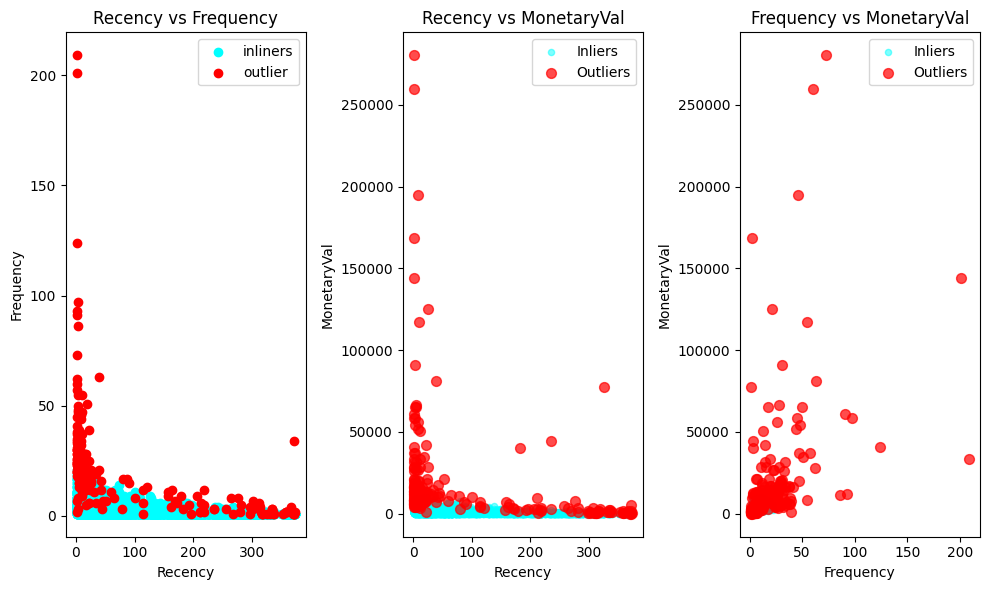

In [8]:
#outlier removal
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination=0.05)

labels = model.fit_predict(rfm[['Recency', 'Frequency', 'MonetaryVal']])
rfm_outlier = rfm[labels == 1]

# rfm_outlier_cpy = rfm.outlier.copy()
inlier = rfm[labels == 1]
outlier = rfm[labels == -1]

fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes[0].scatter(inlier['Recency'], inlier['Frequency'], c = 'cyan', label = 'inliners')
axes[0].scatter(outlier['Recency'], outlier['Frequency'], c = 'red', label = 'outlier')
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Recency vs Frequency')
axes[0].legend()

axes[1].scatter(inlier['Recency'], inlier['MonetaryVal'], c='cyan', alpha=0.5, label='Inliers', s=20)
axes[1].scatter(outlier['Recency'], outlier['MonetaryVal'], c='red', alpha=0.7, label='Outliers', s=50)
axes[1].set_xlabel('Recency')
axes[1].set_ylabel('MonetaryVal')
axes[1].set_title('Recency vs MonetaryVal')
axes[1].legend()

axes[2].scatter(inlier['Frequency'], inlier['MonetaryVal'], c='cyan', alpha=0.5, label='Inliers', s=20)
axes[2].scatter(outlier['Frequency'], outlier['MonetaryVal'], c='red', alpha=0.7, label='Outliers', s=50)
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('MonetaryVal')
axes[2].set_title('Frequency vs MonetaryVal')
axes[2].legend()

plt.tight_layout()
# plt.show()


In [9]:
scaler = StandardScaler()

data_norm = scaler.fit_transform(rfm_outlier)
data = pd.DataFrame(data_norm, columns = rfm_outlier.columns)
data.head()

,Recency,Frequency,MonetaryVal
0,-0.917502,1.142594,2.335936
1,-0.175648,0.204931,0.479077
2,-0.754904,-0.732732,0.449748
3,2.212511,-0.732732,-0.601920
4,-0.571981,1.455148,1.002861


Text(0.5, 1.0, 'Elbow Method')

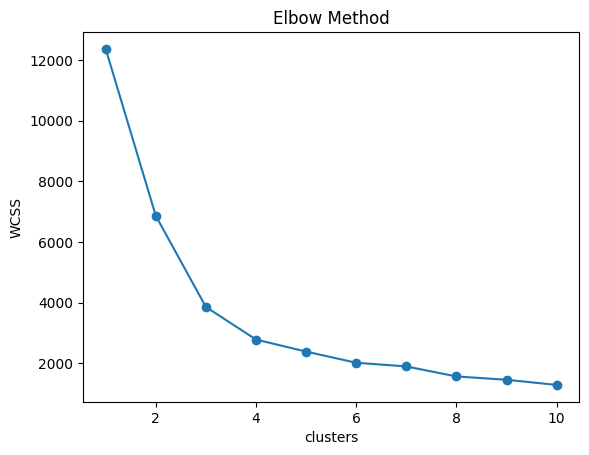

In [10]:
k = math.sqrt(len(data) / 2)
wcss = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, random_state = 0)
  kmeans.fit(data)
  wcss.append(kmeans.inertia_)


plt.plot(range(1, 11), wcss, '-o')
plt.xlabel("clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")


Trying k = 3 and k = 5

In [11]:
# second elbow is at 5 = number of clusters
kmeans = KMeans(n_clusters = 5, random_state = 0)
kmeans.fit(data)
rfm_outlier['Cluster5'] = kmeans.labels_

/tmp/ipython-input-773556684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_outlier['Cluster5'] = kmeans.labels_


In [12]:
kmeans = KMeans(n_clusters = 3, random_state = 0)
kmeans.fit(data)
rfm_outlier['Cluster3'] = kmeans.labels_

cluster_5 = rfm_outlier.groupby('Cluster5').agg({
    'Recency': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'MonetaryVal': ['mean', 'min', 'max']
}).round(3)

cluster_3 = rfm_outlier.groupby('Cluster3').agg({
    'Recency':['mean', 'min', 'max'],
    'Frequency':['mean', 'min', 'max'],
    'MonetaryVal':['mean', 'min', 'max']
}).round(3)

/tmp/ipython-input-4249294125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_outlier['Cluster3'] = kmeans.labels_


### predicting

In [13]:
kmeans_5 = KMeans(n_clusters = 5, random_state = 0)
y_kmeans_5 = kmeans_5.fit_predict(data)

y_kmeans_5

array([0, 2, 1, ..., 1, 0, 1], dtype=int32)

In [14]:
kmeans_3 = KMeans(n_clusters = 3, random_state = 0)
y_kmeans_3 = kmeans_3.fit_predict(data)

### plotting with K = 5

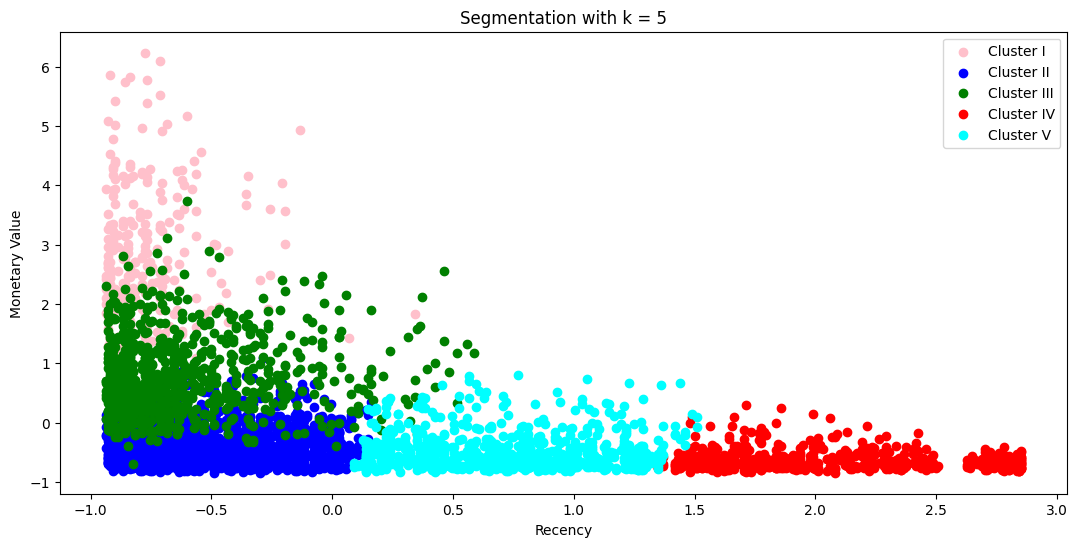

In [15]:
data_arr = data[['Recency', 'Frequency', 'MonetaryVal']].values

fig, axs = plt.subplots(figsize = (13, 6))
axs.scatter(data_arr[y_kmeans_5==0,0], data_arr[y_kmeans_5==0,2], c = 'pink', label = 'Cluster I')
axs.scatter(data_arr[y_kmeans_5==1,0], data_arr[y_kmeans_5==1,2], c = 'blue', label = 'Cluster II')
axs.scatter(data_arr[y_kmeans_5==2,0], data_arr[y_kmeans_5==2,2], c = 'green', label = 'Cluster III')
axs.scatter(data_arr[y_kmeans_5==3,0], data_arr[y_kmeans_5==3,2], c = 'red', label = 'Cluster IV')
axs.scatter(data_arr[y_kmeans_5==4,0], data_arr[y_kmeans_5==4,2], c = 'cyan', label = 'Cluster V')
plt.title('Segmentation with k = 5')

plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.legend()

## plotting k = 3

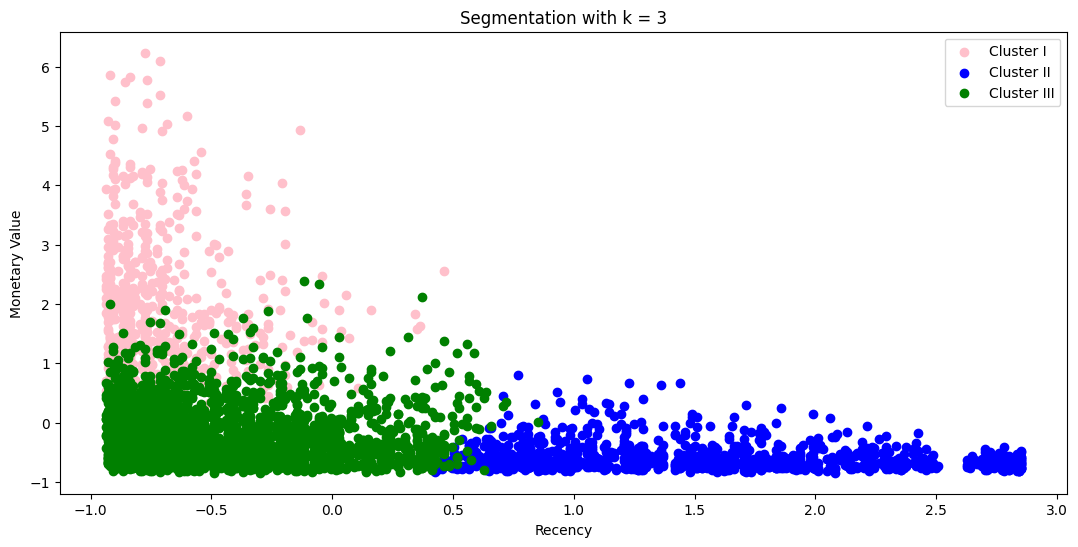

In [16]:
fig, axs = plt.subplots(figsize = (13, 6))
axs.scatter(data_arr[y_kmeans_3==0,0], data_arr[y_kmeans_3==0,2], c = 'pink', label = 'Cluster I')
axs.scatter(data_arr[y_kmeans_3==1,0], data_arr[y_kmeans_3==1,2], c = 'blue', label = 'Cluster II')
axs.scatter(data_arr[y_kmeans_3==2,0], data_arr[y_kmeans_3==2,2], c = 'green', label = 'Cluster III')
plt.title('Segmentation with k = 3')

plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.legend()